# Семинар 9 - ANOVA/ANCOVA

План: 

  3. ANCOVA и её assumptions
  4. SSANOVA(?)

In [1]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
sns.set(font_scale=1.5)
warnings.simplefilter("ignore")

## Данные для экспериментов

![](cylinders.jpeg)

Мы будем смотреть на MPG(=Miles Per Gallon) и сравнивать их средние значения для:

  1. разных количеств цилиндров;
  2. разных стран.

In [2]:
auto_mpg = pd.read_csv('./auto_mpg.data',sep='\s+',names = ['MPG','Cylinders','Displacement',
                                                        'Horse_power','Weight','Acceleration',
                                                        'Model_Year','Origin','Car_Name'])
auto_mpg = auto_mpg[auto_mpg.Horse_power.apply(lambda x: not '?' in x)]
auto_mpg.Horse_power = auto_mpg.Horse_power.apply(lambda x: float(x))
auto_mpg.reset_index(drop=True, inplace=True)

In [3]:
auto_mpg.head()

,MPG,Cylinders,Displacement,Horse_power,Weight,Acceleration,Model_Year,Origin,Car_Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


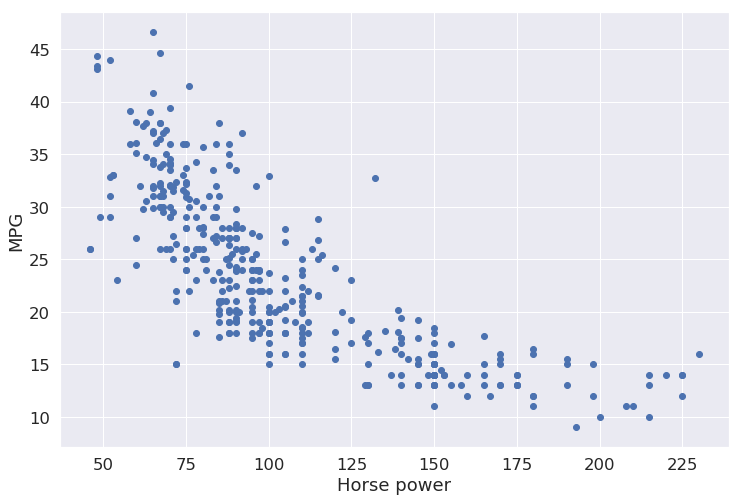

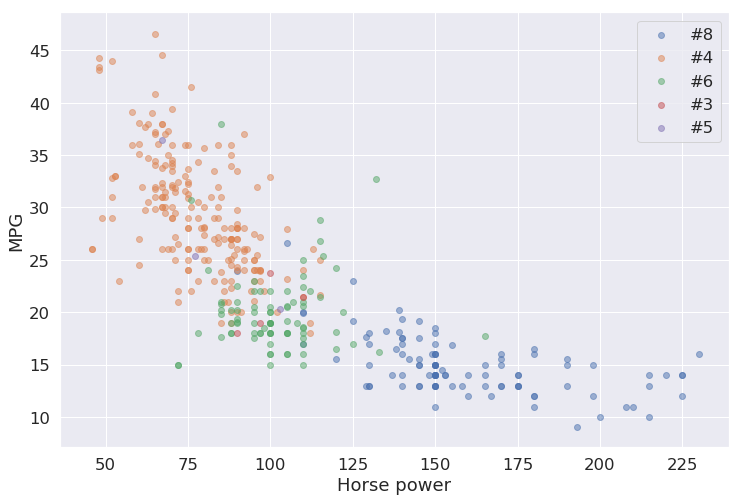

In [4]:
plt.figure(figsize=(12, 8))
plt.scatter(auto_mpg['Horse_power'], auto_mpg['MPG'])
plt.xlabel('Horse power')
plt.ylabel('MPG')
plt.show()

plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.scatter(auto_mpg['Horse_power'][auto_mpg.Cylinders==cylinder], 
                auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], alpha=0.5, 
                label='#{}'.format(cylinder))
plt.xlabel('Horse power')
plt.ylabel('MPG')
plt.legend()
plt.show()

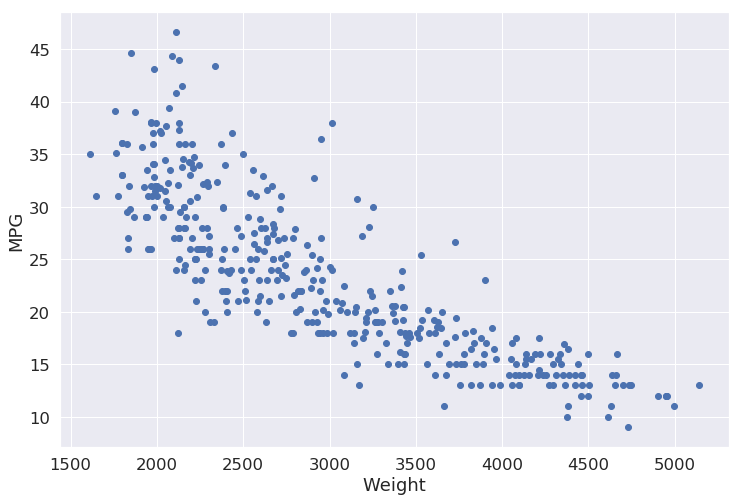

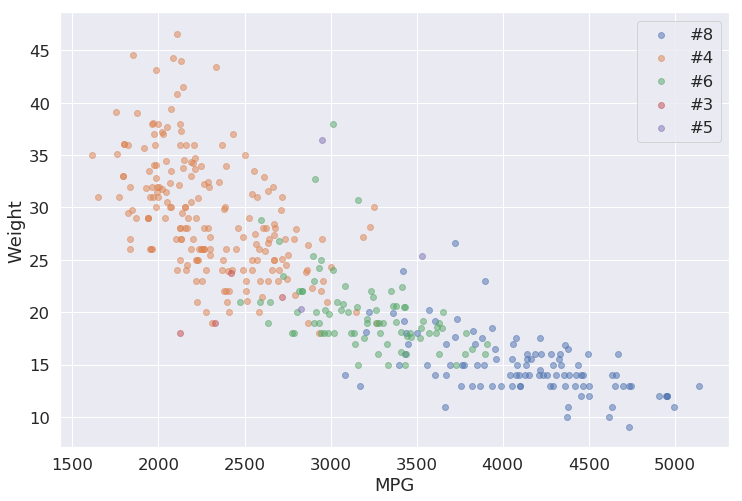

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(auto_mpg['Weight'], auto_mpg['MPG'])
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.show()

plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.scatter(auto_mpg['Weight'][auto_mpg.Cylinders==cylinder], 
                auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], 
                alpha=0.5, label='#{}'.format(cylinder))
plt.xlabel('MPG')
plt.ylabel('Weight')
plt.legend()
plt.show()

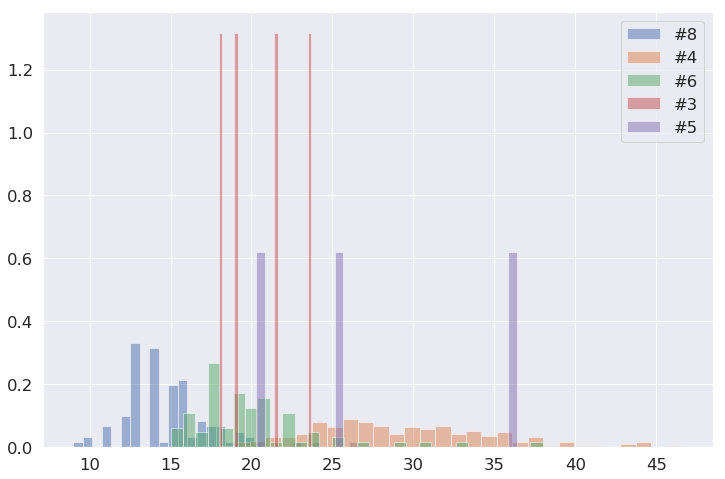

<Figure size 432x288 with 0 Axes>

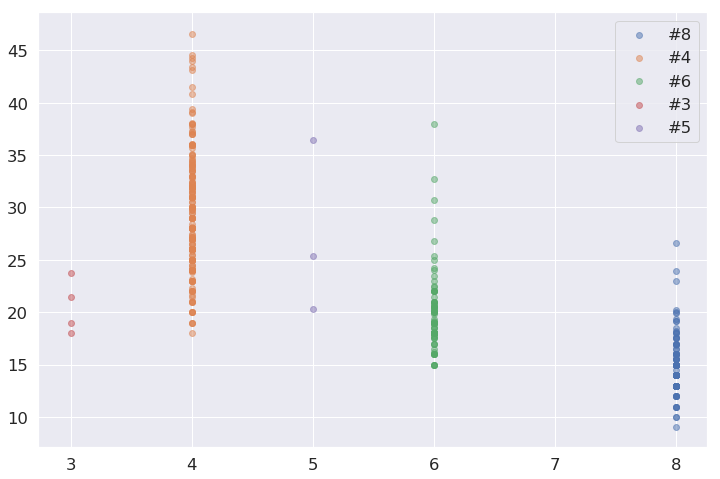

In [6]:
plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.hist(auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], 
             bins=30, alpha=0.5, label='#{}'.format(cylinder), density=True)
plt.legend()
plt.show()

fig = plt.figure()
plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.scatter([cylinder] * len(auto_mpg['MPG'][auto_mpg.Cylinders==cylinder]), 
                auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], alpha=0.5, 
            label='#{}'.format(cylinder))
plt.legend()
plt.show()

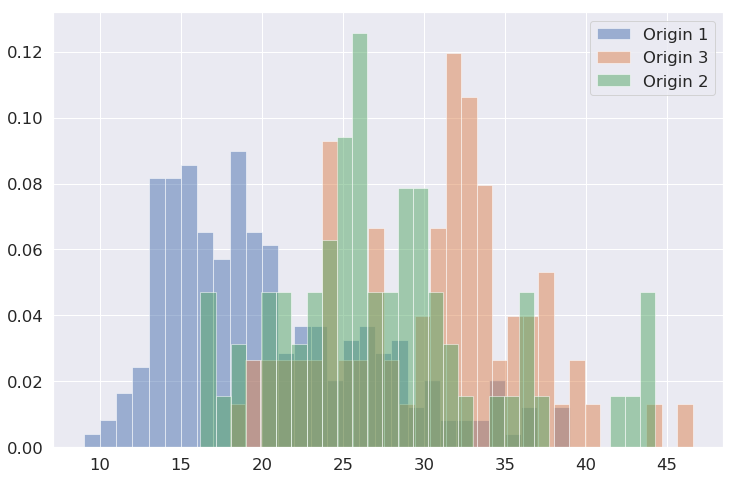

<Figure size 432x288 with 0 Axes>

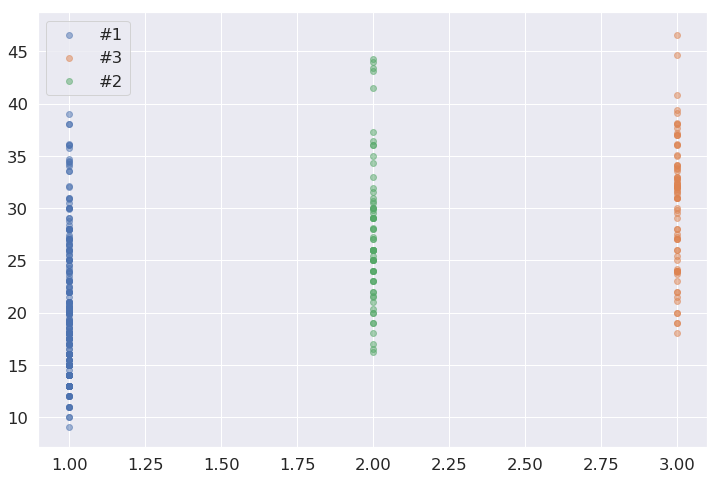

In [7]:
plt.figure(figsize=(12, 8))
for origin in auto_mpg.Origin.unique():
    plt.hist(auto_mpg['MPG'][auto_mpg.Origin==origin], 
             bins=30, alpha=0.5, label='Origin {}'.format(origin), density=True)
plt.legend()
plt.show()

fig = plt.figure()
plt.figure(figsize=(12, 8))
for origin in auto_mpg.Origin.unique():
    plt.scatter([origin] * len(auto_mpg['MPG'][auto_mpg.Origin==origin]), 
                auto_mpg['MPG'][auto_mpg.Origin==origin], alpha=0.5, 
                label='#{}'.format(origin))
plt.legend()
plt.show()

# F-test & ANOVA

Распределение:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a55e68498f7fd2c02998e8692ce340c3e9a5cedf)

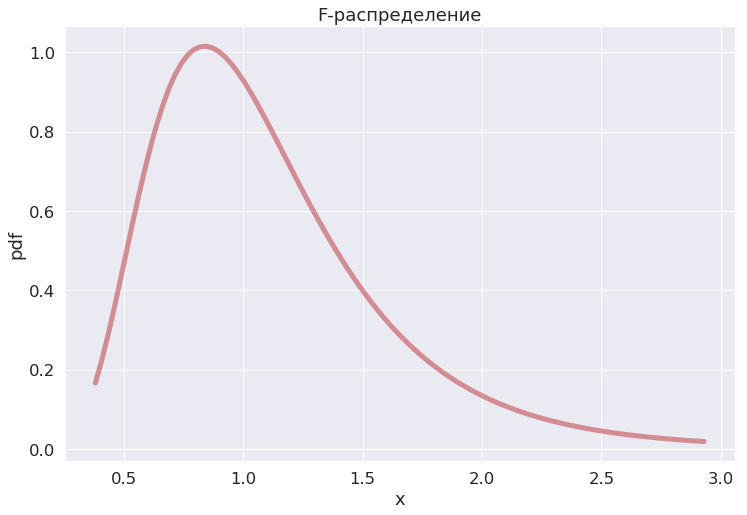

In [8]:
from scipy.stats import f
dfn, dfd = 29, 18

x = np.linspace(f.ppf(0.01, dfn, dfd),
                f.ppf(0.99, dfn, dfd), 100)

plt.figure(figsize=(12, 8))

plt.plot(x, f.pdf(x, dfn, dfd), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.title('F-распределение')

plt.xlabel('x')
plt.ylabel('pdf')

plt.show()

# Самая главная табличка ANOVA

Две гипотезы:

$H_0:$ все средние равны $vs$ $H_1:$ какие-то не равны.
 
| Тип вариации  |  SS | df  | MS  | F  |
|---|---|---|---|---|
| Между групп  | SSG | k - 1 | MSG = SSG / (k - 1)  |  MSG / MSE |
| Внутри группами  | SSE  | n - k  | MSE = SSE / (n - k)  |   |
| Полная  |  SST | n - 1  |   |   |


Что значит тип вариации?

  * Между группами(MSG): вариация между средними подсчитанными для каждой из группы и глобальным средним;
  * Внутри групп(MSE): вариация между измерениями и групповыми средними;
  * Полная: вариация между измерениями и глобальным средним.
 
F-статистика:

$$F = \frac{MSG}{MSE}$$

Если нулевая гипотеза гипотеза верна, то $F$-статистика должна иметь F-распределение со степенями свободы $k-1$ и $n - k$.

Если $P(F_{k-1, n - k} > F) < \alpha$, то $H_0$ отклоняется.

# ANOVA в `statsmodels`

In [9]:
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

Зафитируем линейную модель:

In [10]:
formula = 'MPG ~ C(Cylinders)'
lm = ols(formula, auto_mpg).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     173.0
Date:                Tue, 12 Feb 2019   Prob (F-statistic):           8.79e-85
Time:                        16:08:45   Log-Likelihood:                -1160.3
No. Observations:                 392   AIC:                             2331.
Df Residuals:                     387   BIC:                             2350.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            20.5500      2.34

In [11]:
lm.model.data.orig_exog[:5]

,Intercept,C(Cylinders)[T.4],C(Cylinders)[T.5],C(Cylinders)[T.6],C(Cylinders)[T.8]
0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0


In [12]:
lm.model.data.frame[:5]

,MPG,Cylinders,Displacement,Horse_power,Weight,Acceleration,Model_Year,Origin,Car_Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [13]:
infl = lm.get_influence()
infl.summary_table()

obs,endog,fitted,Cook's,student.,hat diag,dffits,ext.stud.,dffits
,,value,d,residual,,internal,residual,
0.0,18.0,14.963106796116502,0.0008270864444787262,0.6494721600531845,0.009708737864077693,0.06430732635084148,0.6489862865832368,0.06425921770859484
1.0,15.0,14.963106796116502,1.220631596048804e-07,0.007890007059470175,0.009708737864077641,0.0007812271104002996,0.007879807291997812,0.0007802171829301303
2.0,18.0,14.963106796116502,0.0008270864444787244,0.6494721600531845,0.009708737864077673,0.06430732635084141,0.6489862865832365,0.06425921770859476
3.0,16.0,14.963106796116502,9.641839983458376e-05,0.22175072472404161,0.009708737864077678,0.021956593523880675,0.2214781110473463,0.021929600747664504
4.0,17.0,14.963106796116502,0.00037207319360762364,0.4356114423886131,0.009708737864077673,0.04313195993736104,0.4351549705024037,0.04308676248570423
5.0,15.0,14.963106796116502,1.2206315960488075e-07,0.007890007059470175,0.009708737864077669,0.0007812271104003008,0.007879807291997812,0.0007802171829301315
6.0,14.0,14.963106796116502,8.318418358268702e-05,-0.20597071060510128,0.009708737864077669,-0.020394139303080067,-0.2057157022972008,-0.020368889718129436
7.0,14.0,14.963106796116502,8.318418358268702e-05,-0.20597071060510128,0.009708737864077669,-0.020394139303080067,-0.2057157022972008,-0.020368889718129436
8.0,14.0,14.963106796116502,8.318418358268702e-05,-0.20597071060510128,0.009708737864077669,-0.020394139303080067,-0.2057157022972008,-0.020368889718129436


Теперь построим ошибки(residuals).

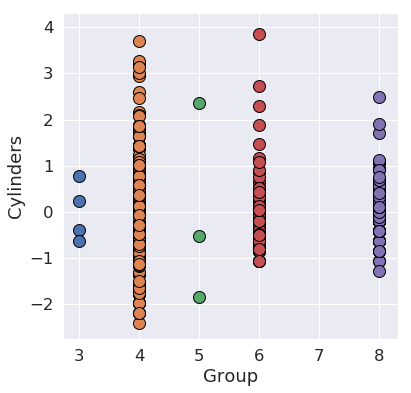

In [14]:
resid = infl.resid_studentized_internal
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Cylinders']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Cylinders');

In [15]:
anova_table = anova_lm(lm)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Cylinders),4.0,15274.506767,3818.626692,172.954629,8.785541e-85
Residual,387.0,8544.486702,22.078777,NaN,NaN


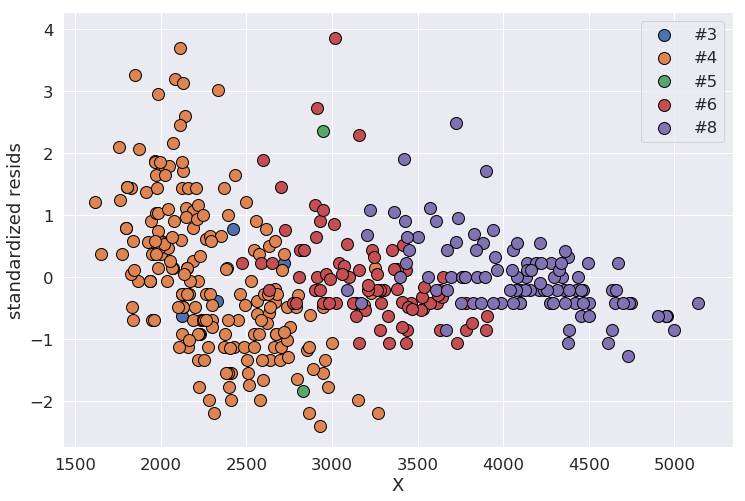

In [16]:
infl = lm.get_influence()
resid = infl.resid_studentized_internal
plt.figure(figsize=(12, 8))
for cylinder, group in auto_mpg.groupby(['Cylinders']):
    plt.scatter(auto_mpg.Weight[group.index], resid[group.index], s=144, 
                edgecolors='black', label='#{}'.format(cylinder))
plt.xlabel('X');
plt.ylabel('standardized resids');
plt.legend();

In [17]:
formula = 'MPG ~ C(Origin)'
lm = ols(formula, auto_mpg).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     96.60
Date:                Tue, 12 Feb 2019   Prob (F-statistic):           8.67e-35
Time:                        16:08:46   Log-Likelihood:                -1282.2
No. Observations:                 392   AIC:                             2570.
Df Residuals:                     389   BIC:                             2582.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         20.0335      0.409     49.

In [18]:
anova_table = anova_lm(lm)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Origin),2.0,7904.291038,3952.145519,96.60153,8.673818e-35
Residual,389.0,15914.702431,40.911831,NaN,NaN


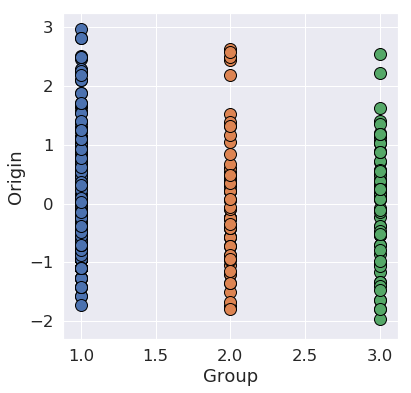

In [19]:
infl = lm.get_influence()

resid = infl.resid_studentized_internal
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Origin']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Origin');

# Two-Way ANOVA

In [20]:
formula = 'MPG ~ C(Cylinders) + C(Origin) + C(Cylinders) * C(Origin)'
lm = ols(formula, auto_mpg).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     96.84
Date:                Tue, 12 Feb 2019   Prob (F-statistic):           3.69e-87
Time:                        16:08:47   Log-Likelihood:                -1144.4
No. Observations:                 392   AIC:                             2307.
Df Residuals:                     383   BIC:                             2343.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [42]:
anova_table = anova_lm(lm, typ=1)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Cylinders),4.0,15274.506767,3818.626692,235.386220,1.143764e-101
Weight,1.0,1991.985372,1991.985372,122.789145,6.226440e-25
C(Cylinders):Weight,4.0,355.386654,88.846663,5.476650,2.690234e-04
Residual,382.0,6197.114676,16.222813,NaN,NaN


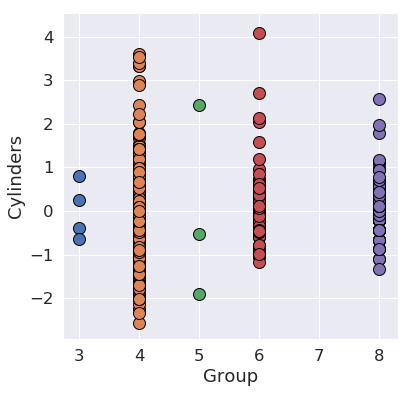

In [22]:
infl = lm.get_influence()

resid = infl.resid_studentized_internal
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Cylinders']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Cylinders');

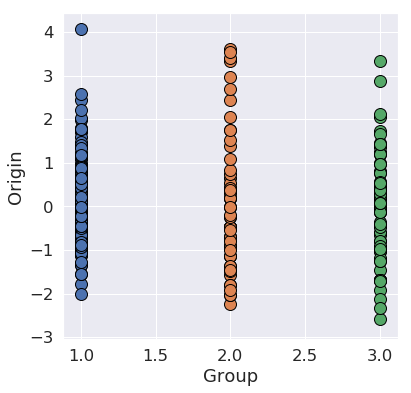

In [23]:
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Origin']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Origin');

## А теперь чуть больше информации о том что происходит

### Как считается F-статистика?

$$F = \frac{SSE_R - SSE_F}{df_R - df_F} \frac{df_F}{SSE_F},$$

где индекс $F$ обозначает полную модель, а индекс $R$ обозначает усечённую модель.

### Три способа ввести полную и усечённую модель

Они обозначаются как I, II и III в литературе(неофициальная, но широко используемая терминология).

##### I.

  * SS(A)
  * SS(B|A)
  * SS(AB|B, A)
  
###### II.
  * SS(A|B)
  * SS(B|A)
  
###### III. 
  * SS(A|B, AB)
  * SS(B|A, AB)

In [45]:
import IPython
for typ in ['I', 'II', 'III']:
    anova_table = anova_lm(lm, typ=typ)
    IPython.display.display(anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
C(Cylinders),4.0,15274.506767,3818.626692,235.386220,1.143764e-101
Weight,1.0,1991.985372,1991.985372,122.789145,6.226440e-25
C(Cylinders):Weight,4.0,355.386654,88.846663,5.476650,2.690234e-04
Residual,382.0,6197.114676,16.222813,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Cylinders),768.732377,4.0,11.846471,4.407009e-09
Weight,1991.985372,1.0,122.789145,6.226440e-25
C(Cylinders):Weight,355.386654,4.0,5.476650,2.690234e-04
Residual,6197.114676,382.0,NaN,NaN


,sum_sq,df,F,PR(>F)
Intercept,0.846312,1.0,0.052168,0.819455
C(Cylinders),488.787456,4.0,7.532409,0.000008
Weight,7.563883,1.0,0.466250,0.495131
C(Cylinders):Weight,355.386654,4.0,5.476650,0.000269
Residual,6197.114676,382.0,NaN,NaN


# ANCOVA

В ANCOVA(Analysis of covariance) добавляется ещё регрессия от некоторой величины, которая может оказывать влияние на интересующие нас переменные.

Если мы правильно выбрали регрессор, то вариация остатков должна уменьшиться.

Но при этом возможно увеличение дисперсии.

In [33]:
lm = ols("MPG ~ C(Cylinders) + Weight + C(Cylinders) * Weight", auto_mpg).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     120.7
Date:                Tue, 12 Feb 2019   Prob (F-statistic):          6.26e-106
Time:                        17:20:40   Log-Likelihood:                -1097.3
No. Observations:                 392   AIC:                             2215.
Df Residuals:                     382   BIC:                             2254.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.1663     22.619      0.228      0.819     -39.308      49.640
C(Cylinders)[T.4]           44.5403     22.703      1.962      0.051      -0.098      89.178
C(Cylinders)[T.5]           25.4410     32.780      0.776      0.438     -39.010      89.892
C(Cylinders)[T.6]           31.8914     23.026      1.385      0.167     -13.382      77.165
C(Cylinders)[T.8]           24.2775     22.916      1.059      0.290     -20.780      69.335
Weight                       0.0064      0.009      0.683      0.495      -0.012       0.025
C(Cylinders)[T.4]:Weight    -0.0153      0.009     -1.620      0.106      -0.034       0.003
C(Cylinders)[T.5]:Weight    -0.0075      0.012     -0.617      0.538      -0.031       0.016
C(Cylinders)[T.6]:Weight    -0.0117      0.009     -1.238      0.216      -0.030       0.007
C(Cylinders)[T.8]:Weight    -0.0099      0.009     -1.053      0.293      -0.028       0.009
==============================================================================
Omnibus:                       62.054   Durbin-Watson:                   0.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.478
Skew:                           0.883   Prob(JB):                     3.09e-26
Kurtosis:                       5.018   Cond. No.                     9.25e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
anova_table = anova_lm(lm)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Cylinders),4.0,15274.506767,3818.626692,235.386220,1.143764e-101
Weight,1.0,1991.985372,1991.985372,122.789145,6.226440e-25
C(Cylinders):Weight,4.0,355.386654,88.846663,5.476650,2.690234e-04
Residual,382.0,6197.114676,16.222813,NaN,NaN


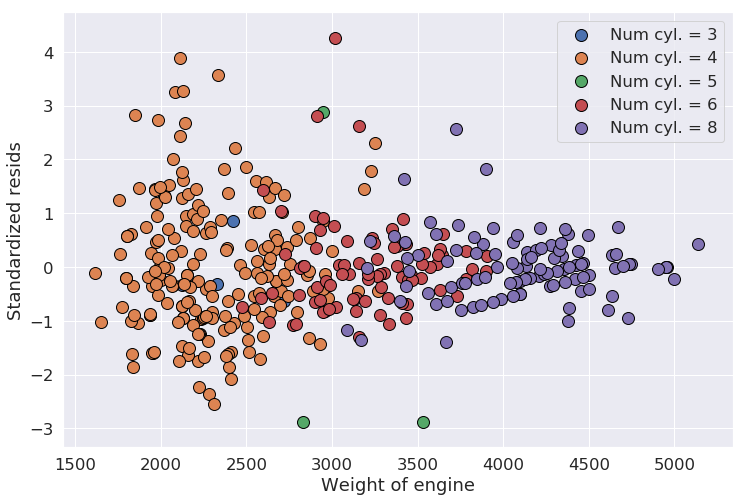

In [35]:
infl = lm.get_influence()
resid = infl.resid_studentized_internal
plt.figure(figsize=(12, 8))
for cylinder, group in auto_mpg.groupby(['Cylinders']):
    plt.scatter(auto_mpg.Weight[group.index], resid[group.index], s=144, 
                edgecolors='black', label='Num cyl. = {}'.format(cylinder))
plt.xlabel('Weight of engine');
plt.ylabel('Standardized resids');
plt.legend();

In [ ]:
anova_table = anova_lm(lm, typ=1)
anova_table

# SSANOVA